In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#from gensim.models import Word2Vec

import seaborn as sns
import matplotlib.pyplot as plt

# --- Download NLTK resources (only need to do this once) ---
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # Open Multilingual Wordnet

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Abdo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abdo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Abdo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Abdo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
df = pd.read_csv('./data/emails.csv')
df

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [4]:
print("Null values:\n", df.isnull().sum())

Null values:
 text    0
spam    0
dtype: int64


In [5]:
print("\nLabel distribution:\n", df['spam'].value_counts())


Label distribution:
 spam
0    4360
1    1368
Name: count, dtype: int64


In [20]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Abdo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [7]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Cleans and preprocesses a single text message.
    """
    # 1. Lowercasing
    text = text.lower()
    
    # 2. Tokenization
    tokens = word_tokenize(text)
    
    # 3. Remove punctuation and non-alphanumeric characters
    tokens = [word for word in tokens if word.isalpha()]
    
    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # 5. Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    return " ".join(tokens)

# Apply the preprocessing function to the 'message' column
print("\nStarting text preprocessing...")
df['processed_message'] = df['text'].apply(preprocess_text)
print("Preprocessing complete.")
print("\nSample of processed data:")
print(df.head())


Starting text preprocessing...
Preprocessing complete.

Sample of processed data:
                                                text  spam  \
0  Subject: naturally irresistible your corporate...     1   
1  Subject: the stock trading gunslinger  fanny i...     1   
2  Subject: unbelievable new homes made easy  im ...     1   
3  Subject: 4 color printing special  request add...     1   
4  Subject: do not have money , get software cds ...     1   

                                   processed_message  
0  subject naturally irresistible corporate ident...  
1  subject stock trading gunslinger fanny merrill...  
2  subject unbelievable new home made easy im wan...  
3  subject color printing special request additio...  
4  subject money get software cd software compati...  


In [8]:
# Define features (X) and target (y)
X = df['processed_message']
y = df['spam']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 4582
Test set size: 1146


### Approach 1: Bag of Words (BoW)


--- Model 1: Bag of Words (BoW) ---
BoW Model Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       872
           1       0.96      0.98      0.97       274

    accuracy                           0.99      1146
   macro avg       0.98      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146

Accuracy: 0.9860


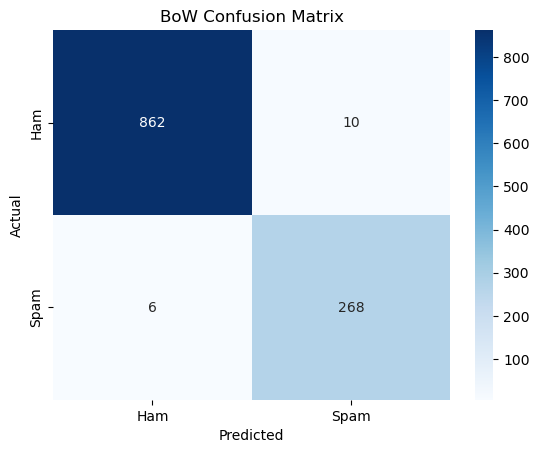

In [13]:
print("\n--- Model 1: Bag of Words (BoW) ---")

# 1. Vectorize the text data
bow_vectorizer = CountVectorizer(max_features = 2500, ngram_range=(1,2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# 2. Train the Logistic Regression model
lr_bow = LogisticRegression(max_iter=500)
lr_bow.fit(X_train_bow, y_train)

# 3. Make predictions and evaluate
y_pred_bow = lr_bow.predict(X_test_bow)

print("BoW Model Performance:")
print(classification_report(y_test, y_pred_bow))
print(f"Accuracy: {accuracy_score(y_test, y_pred_bow):.4f}")

# Confusion Matrix
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('BoW Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Approach 2: TF-IDF


--- Model 2: TF-IDF ---
TF-IDF Model Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       872
           1       0.98      0.93      0.96       274

    accuracy                           0.98      1146
   macro avg       0.98      0.96      0.97      1146
weighted avg       0.98      0.98      0.98      1146

Accuracy: 0.9799


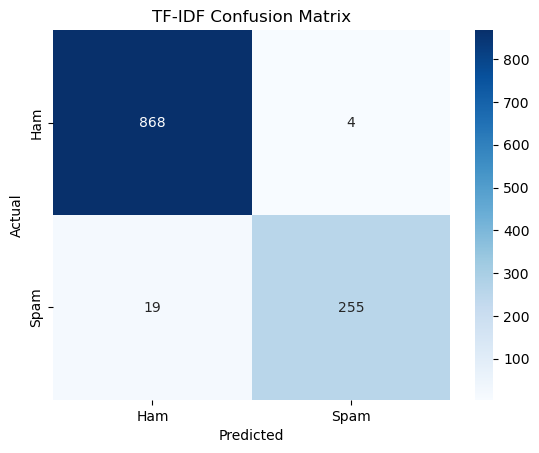

In [31]:
print("\n--- Model 2: TF-IDF ---")

# 1. Vectorize the text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 2. Train the Logistic Regression model
lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)

# 3. Make predictions and evaluate
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

print("TF-IDF Model Performance:")
print(classification_report(y_test, y_pred_tfidf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf):.4f}")

# Confusion Matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('TF-IDF Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()